In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive thresholding to handle varying lighting
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2)
    
    # Apply morphological operations to enhance suture lines
    kernel = np.ones((3, 3), np.uint8)
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # Find the region of interest (the practice pad)
    contours, _ = cv2.findContours(
        morphed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour is the practice pad
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [largest_contour], 0, 255, -1)
        
        # Apply the mask to focus only on the pad area
        roi = cv2.bitwise_and(morphed, mask)
        return roi, mask
    
    return morphed, np.ones_like(gray) * 255

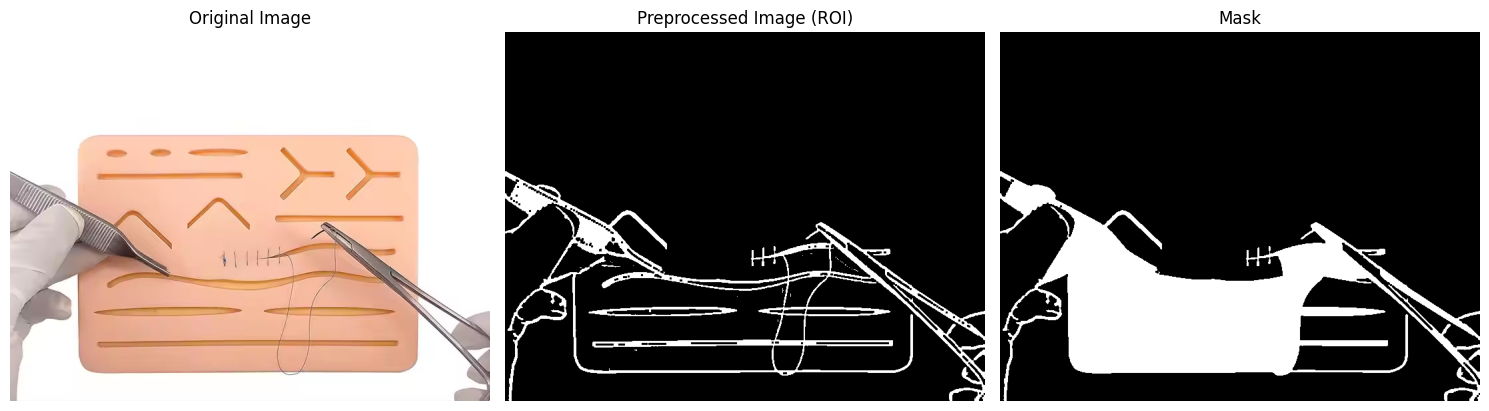

In [2]:
# Load a sample image - replace 'path_to_sample_image.jpg' with your actual image path
image = cv2.imread('sample.png')

# Display the original image (convert from BGR to RGB for proper display)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Process the image
roi, mask = preprocess_image(image)

# Display the preprocessed result
plt.subplot(1, 3, 2)
plt.imshow(roi, cmap='gray')
plt.title('Preprocessed Image (ROI)')
plt.axis('off')

# Display the mask
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
def detect_sutures_traditional(preprocessed_image):
    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(
        preprocessed_image, 
        rho=1,
        theta=np.pi/180,
        threshold=50,
        minLineLength=50,
        maxLineGap=20
    )
    
    suture_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Filter horizontal-ish lines (sutures are generally horizontal)
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
            if 160 <= angle <= 180 or 0 <= angle <= 20:
                suture_lines.append(((x1, y1), (x2, y2)))
    
    return suture_lines

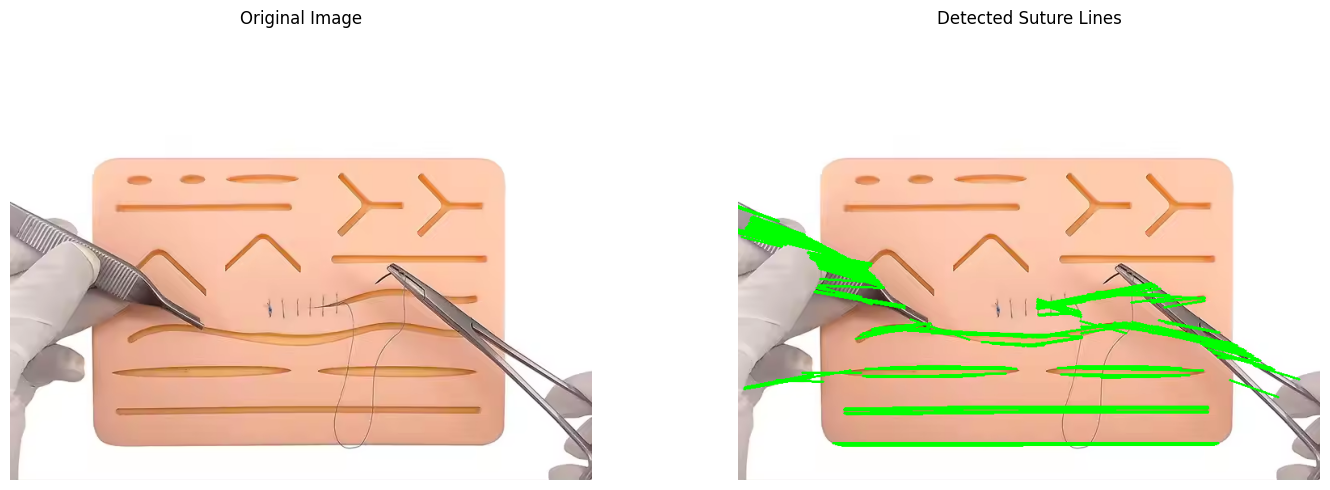

Number of detected suture lines: 137


In [4]:
# Detect suture lines using the traditional method
suture_lines = detect_sutures_traditional(roi)

# Create a copy of the original image to draw lines on
result_image = image.copy()

# Draw detected suture lines
for (x1, y1), (x2, y2) in suture_lines:
    cv2.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Suture Lines')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the number of detected suture lines
print(f"Number of detected suture lines: {len(suture_lines)}")

In [5]:
def analyze_suture_quality(suture_lines, original_image):
    if len(suture_lines) < 2:
        return {"error": "Not enough sutures detected"}
    
    # Sort lines by y-coordinate (top to bottom)
    suture_lines.sort(key=lambda line: (line[0][1] + line[1][1]) / 2)
    
    # Calculate angles for each line
    angles = []
    for ((x1, y1), (x2, y2)) in suture_lines:
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        # Normalize angle to 0-180
        if angle < 0:
            angle += 180
        angles.append(angle)
    
    # Calculate mean angle and deviation for parallelism check
    mean_angle = np.mean(angles)
    angle_deviations = [abs(angle - mean_angle) for angle in angles]
    
    # Calculate distances between adjacent lines
    distances = []
    for i in range(len(suture_lines) - 1):
        line1 = suture_lines[i]
        line2 = suture_lines[i + 1]
        
        # Calculate midpoints of each line
        mid1 = ((line1[0][0] + line1[1][0]) / 2, (line1[0][1] + line1[1][1]) / 2)
        mid2 = ((line2[0][0] + line2[1][0]) / 2, (line2[0][1] + line2[1][1]) / 2)
        
        # Calculate perpendicular distance
        dist = np.abs(mid2[1] - mid1[1])
        distances.append(dist)
    
    # Evaluate quality metrics
    avg_distance = np.mean(distances)
    distance_variance = np.var(distances)
    max_angle_deviation = max(angle_deviations)
    
    # Define quality thresholds
    angle_threshold = 5.0  # degrees
    distance_variance_threshold = 25.0  # pixels^2
    
    # Classify each suture
    suture_quality = []
    for i, line in enumerate(suture_lines):
        quality = {}
        quality["line"] = line
        
        # Check parallelism
        if i < len(angle_deviations):
            quality["angle_deviation"] = angle_deviations[i]
            quality["is_parallel"] = angle_deviations[i] < angle_threshold
        
        # Check distance (for all but the first line)
        if i > 0:
            prev_distance = distances[i-1]
            distance_deviation = abs(prev_distance - avg_distance)
            quality["distance_deviation"] = distance_deviation
            quality["even_spacing"] = distance_deviation < np.sqrt(distance_variance_threshold)
        
        # Overall quality assessment
        if i > 0:
            quality["overall_good"] = quality["is_parallel"] and quality["even_spacing"]
        else:
            quality["overall_good"] = quality["is_parallel"]
        
        suture_quality.append(quality)
    
    # Overall assessment
    overall_assessment = {
        "parallelism": max_angle_deviation < angle_threshold,
        "even_spacing": distance_variance < distance_variance_threshold,
        "sutures_detected": len(suture_lines),
        "mean_angle": mean_angle,
        "mean_distance": avg_distance,
        "individual_sutures": suture_quality
    }
    
    return overall_assessment

In [6]:
def visualize_results(original_image, suture_analysis):
    # Create a copy of the image to draw on
    output_image = original_image.copy()
    
    # Draw each suture with appropriate color
    for suture in suture_analysis["individual_sutures"]:
        line = suture["line"]
        p1, p2 = line
        
        # Determine color based on quality
        if suture.get("overall_good", False):
            color = (0, 255, 0)  # Green for good
        else:
            color = (0, 0, 255)  # Red for bad
        
        # Draw the suture line
        cv2.line(output_image, p1, p2, color, 2)
        
        # Add annotations for issues
        if not suture.get("is_parallel", True):
            # Draw angle deviation annotation
            midpoint = ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)
            cv2.putText(output_image, f"{suture['angle_deviation']:.1f}°", 
                       (midpoint[0] + 10, midpoint[1]), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        if not suture.get("even_spacing", True) and "distance_deviation" in suture:
            # Draw spacing deviation annotation
            midpoint = ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)
            cv2.putText(output_image, f"{suture['distance_deviation']:.1f}px", 
                       (midpoint[0] - 60, midpoint[1]), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    # Add overall assessment
    cv2.putText(output_image, 
               f"Detected: {suture_analysis['sutures_detected']} sutures", 
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    parallel_text = "Parallel: YES" if suture_analysis["parallelism"] else "Parallel: NO"
    cv2.putText(output_image, parallel_text, 
               (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 
               (0, 255, 0) if suture_analysis["parallelism"] else (0, 0, 255), 2)
    
    spacing_text = "Even Spacing: YES" if suture_analysis["even_spacing"] else "Even Spacing: NO"
    cv2.putText(output_image, spacing_text, 
               (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 
               (0, 255, 0) if suture_analysis["even_spacing"] else (0, 0, 255), 2)
    
    return output_image

In [7]:
def visualize_results_matplotlib(original_image, suture_analysis):
    # Create figure and display the image
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    
    # Draw each suture with appropriate color
    for suture in suture_analysis["individual_sutures"]:
        line = suture["line"]
        (x1, y1), (x2, y2) = line
        
        # Determine color based on quality
        color = 'g' if suture.get("overall_good", False) else 'r'
        
        # Draw the suture line
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)
        
        # Add annotations for issues
        midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)
        if not suture.get("is_parallel", True):
            # Draw angle deviation annotation
            ax.text(midpoint[0] + 10, midpoint[1], f"{suture['angle_deviation']:.1f}°", 
                   color='blue', fontsize=10)
        
        if not suture.get("even_spacing", True) and "distance_deviation" in suture:
            # Draw spacing deviation annotation
            ax.text(midpoint[0] - 60, midpoint[1], f"{suture['distance_deviation']:.1f}px", 
                   color='blue', fontsize=10)
    
    # Add overall assessment
    ax.text(10, 30, f"Detected: {suture_analysis['sutures_detected']} sutures", 
            color='black', fontsize=14, weight='bold')
    
    parallel_color = 'green' if suture_analysis["parallelism"] else 'red'
    parallel_text = "Parallel: YES" if suture_analysis["parallelism"] else "Parallel: NO"
    ax.text(10, 60, parallel_text, color=parallel_color, fontsize=14, weight='bold')
    
    spacing_color = 'green' if suture_analysis["even_spacing"] else 'red'
    spacing_text = "Even Spacing: YES" if suture_analysis["even_spacing"] else "Even Spacing: NO"
    ax.text(10, 90, spacing_text, color=spacing_color, fontsize=14, weight='bold')
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Suture Analysis', fontsize=16)
    
    plt.tight_layout()
    return fig, ax

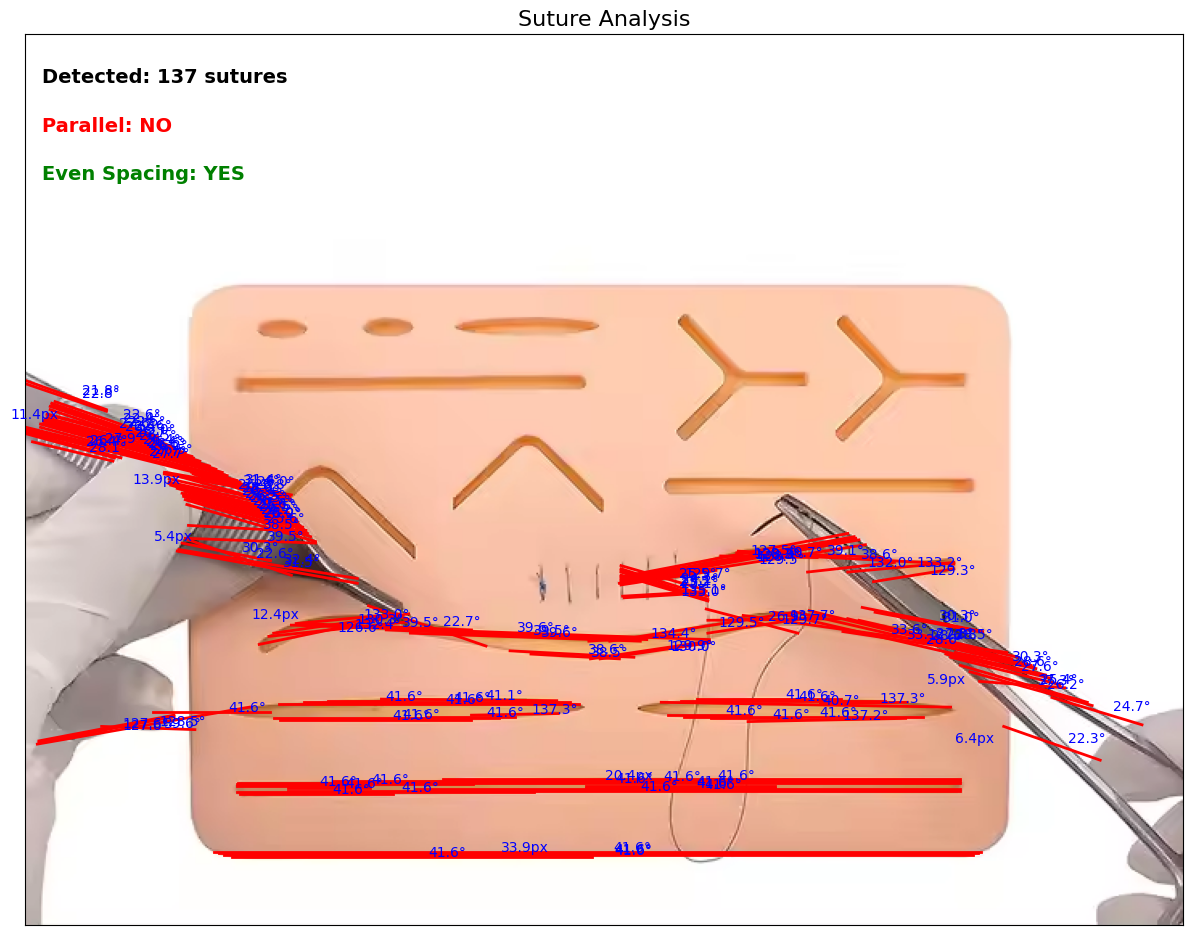

In [8]:
suture_analysis = analyze_suture_quality(suture_lines, image)
fig, ax = visualize_results_matplotlib(image, suture_analysis)
plt.show()